In [46]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine, utils
import torchinfo

In [32]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [33]:
data_path = Path("data/")
image_path = data_path / "soil_low_med_high"

In [34]:
# Get a set of pretrained model weights
weights = torchvision.models.VGG16_BN_Weights.DEFAULT
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [35]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [36]:
#HyperParameters
batch_Size = 4
learning_rate = 0.001
epochS = 10
dropout_prob = 0.2

In [37]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=batch_Size)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x11d1d9374d0>,
 ['high', 'low', 'medium'])

In [38]:
model = torchvision.models.vgg16_bn(weights=weights).to(device)

In [39]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [40]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_prob, inplace=True), 
    nn.Linear(in_features=25088, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [41]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:20<03:02, 20.24s/it]

Epoch: 1 | train_loss: 1.1513 | train_acc: 0.5000 | test_loss: 0.9184 | test_acc: 0.5417


 20%|██        | 2/10 [00:38<02:34, 19.29s/it]

Epoch: 2 | train_loss: 0.2131 | train_acc: 0.9167 | test_loss: 0.7647 | test_acc: 0.6667


 30%|███       | 3/10 [00:58<02:16, 19.43s/it]

Epoch: 3 | train_loss: 0.0692 | train_acc: 0.9881 | test_loss: 0.5742 | test_acc: 0.7083


 40%|████      | 4/10 [01:17<01:55, 19.24s/it]

Epoch: 4 | train_loss: 0.0460 | train_acc: 1.0000 | test_loss: 0.7121 | test_acc: 0.7500


 50%|█████     | 5/10 [01:36<01:35, 19.02s/it]

Epoch: 5 | train_loss: 0.0335 | train_acc: 0.9881 | test_loss: 0.6581 | test_acc: 0.7083


 60%|██████    | 6/10 [01:54<01:15, 18.90s/it]

Epoch: 6 | train_loss: 0.0313 | train_acc: 1.0000 | test_loss: 0.6921 | test_acc: 0.7500


 70%|███████   | 7/10 [02:13<00:56, 18.86s/it]

Epoch: 7 | train_loss: 0.0144 | train_acc: 1.0000 | test_loss: 0.6165 | test_acc: 0.7500


 80%|████████  | 8/10 [02:32<00:37, 18.80s/it]

Epoch: 8 | train_loss: 0.0126 | train_acc: 1.0000 | test_loss: 0.6285 | test_acc: 0.7500


 90%|█████████ | 9/10 [02:50<00:18, 18.73s/it]

Epoch: 9 | train_loss: 0.0188 | train_acc: 1.0000 | test_loss: 0.6480 | test_acc: 0.7500


100%|██████████| 10/10 [03:09<00:00, 18.97s/it]

Epoch: 10 | train_loss: 0.0127 | train_acc: 1.0000 | test_loss: 0.6371 | test_acc: 0.7917
[INFO] Total training time: 189.732 seconds


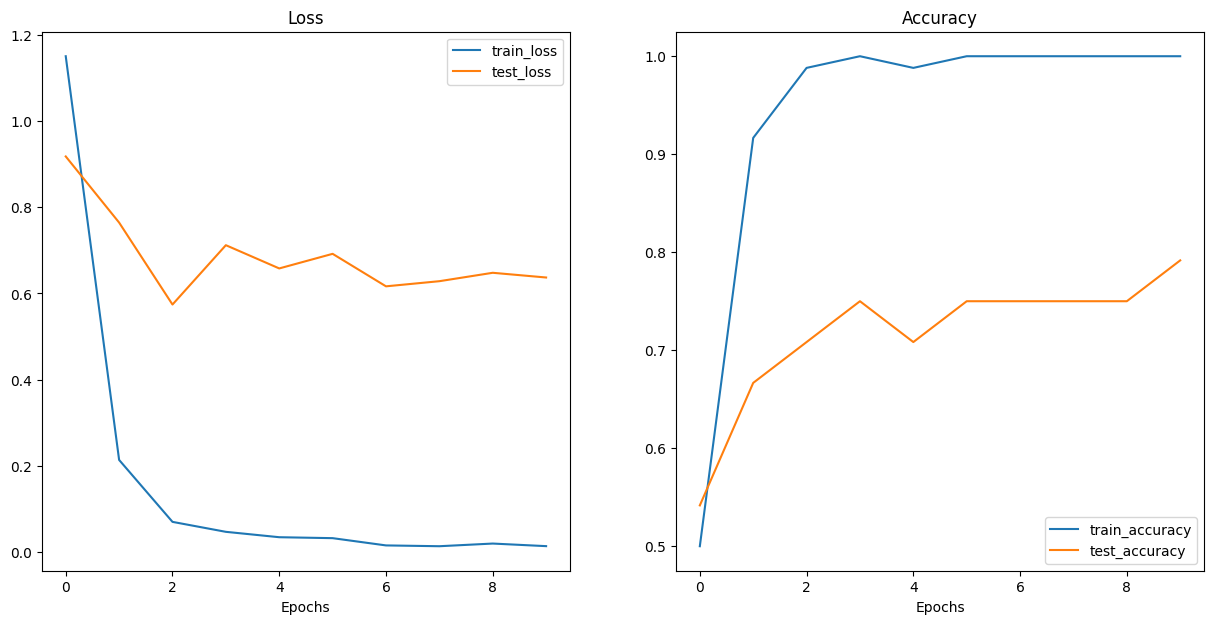

In [43]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)

In [44]:
from winsound import Beep
Beep(300, 200)

In [ ]:
# utils.save_model(model=model,
#                  target_dir="models",
#                  model_name="vgg16_1.pth")

[INFO] Saving model to: models\vgg16_1.pth
